In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import ast

from lib.functions_data import compare_enrollment_registration

In [2]:
import sys
from pathlib import Path
import os
cwd = os.getcwd()
parent = str(Path(cwd).parents[0])
sys.path.append(parent)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
#This is the data scraped from the results section that informs this analysis
results_info = pd.read_csv(parent + '/data/euctr_data_quality_results_scrape_jul_2022.csv')
results_info['trial_start_date'] = pd.to_datetime(results_info.trial_start_date)
results_info_filt = results_info[results_info.recruitment_countries.notnull()].reset_index(drop=True)

In [4]:
protocols = results_info_filt.trial_countries.to_list()
results_countries = results_info_filt.recruitment_countries.to_list()
start_date = results_info_filt.trial_start_date.to_list()
trial_ids = results_info_filt.trial_id.to_list()

zipped_cats = zip(trial_ids, protocols, results_countries, start_date)

results_list = compare_enrollment_registration(zipped_cats)

missing_protocols = pd.DataFrame(results_list)
missing_protocols['total_missing'] = missing_protocols.unaccounted.apply(len)

In [5]:
acct = missing_protocols.accounted.to_list()
unacct = missing_protocols.unaccounted.to_list()
ids = missing_protocols.trial_id.to_list()

In [6]:
#Counting missing protocols

accounted_count = {}
unaccounted_count = {}
for ac, un in zip(acct, unacct):
    if ac:
        for a in ac:
            accounted_count[a] = accounted_count.get(a, 0) + 1
    if un:
        for u in un:
            unaccounted_count[u] = unaccounted_count.get(u, 0) + 1

In [7]:
#Lets see how many participants are covered by missing protocols

unacct_enrollment = 0

for u, rc in zip(unacct, results_countries):
    rc_dict = ast.literal_eval(rc)
    for uc in u:
        unacct_enrollment += rc_dict[uc]

print(f'There are {unacct_enrollment} participants covered by missing protocols')

There are 1211067 participants covered by missing protocols


In [8]:
accounted_series = pd.Series(accounted_count)
unaccounted_series = pd.Series(unaccounted_count)

reg_check_no_buffer = accounted_series.to_frame().join(unaccounted_series.to_frame(), 
                                                       how='outer', rsuffix='unac').rename({'0': 'accounted', 
                                                                                            '0unac': 'unaccounted'}, 
                                                                                           axis=1).fillna(0)

In [9]:
reg_check_no_buffer['total'] = reg_check_no_buffer['accounted'] + reg_check_no_buffer['unaccounted']

reg_check_no_buffer['acct_prct'] = round((reg_check_no_buffer['accounted'] / reg_check_no_buffer['total']) * 100, 2)

reg_check_no_buffer['unacct_prct'] = round((reg_check_no_buffer['unaccounted'] / reg_check_no_buffer['total']) * 100, 2)

reg_check_no_buffer.sort_values(by='unaccounted', ascending=False)

,accounted,unaccounted,total,acct_prct,unacct_prct
France,1628,1393,3021,53.89,46.11
Poland,1676,990,2666,62.87,37.13
Romania,229,799,1028,22.28,77.72
Germany,3992,309,4301,92.82,7.18
Norway,236,256,492,47.97,52.03
United Kingdom,3949,210,4159,94.95,5.05
Italy,2724,170,2894,94.13,5.87
Spain,3356,125,3481,96.41,3.59
Netherlands,1604,89,1693,94.74,5.26
Belgium,2233,79,2312,96.58,3.42


In [10]:
print(f'{round((reg_check_no_buffer.accounted.sum() / reg_check_no_buffer.total.sum()) * 100,2)}% of expected protocols accounted for overall.')

87.62% of expected protocols accounted for overall.


In [11]:
romania = reg_check_no_buffer.loc['Romania']['unaccounted'] 
poland = reg_check_no_buffer.loc['Poland']['unaccounted']
france = reg_check_no_buffer.loc['France']['unaccounted']

top_share = round(((france+poland+romania) / reg_check_no_buffer.unaccounted.sum()) * 100, 2)

print(f'France, Poland, and Romania account for {top_share}% of all missing protocols')
print(f'This is {france+poland+romania} trials.')

France, Poland, and Romania account for 65.18% of all missing protocols
This is 3182.0 trials.


# Paper Figure 1

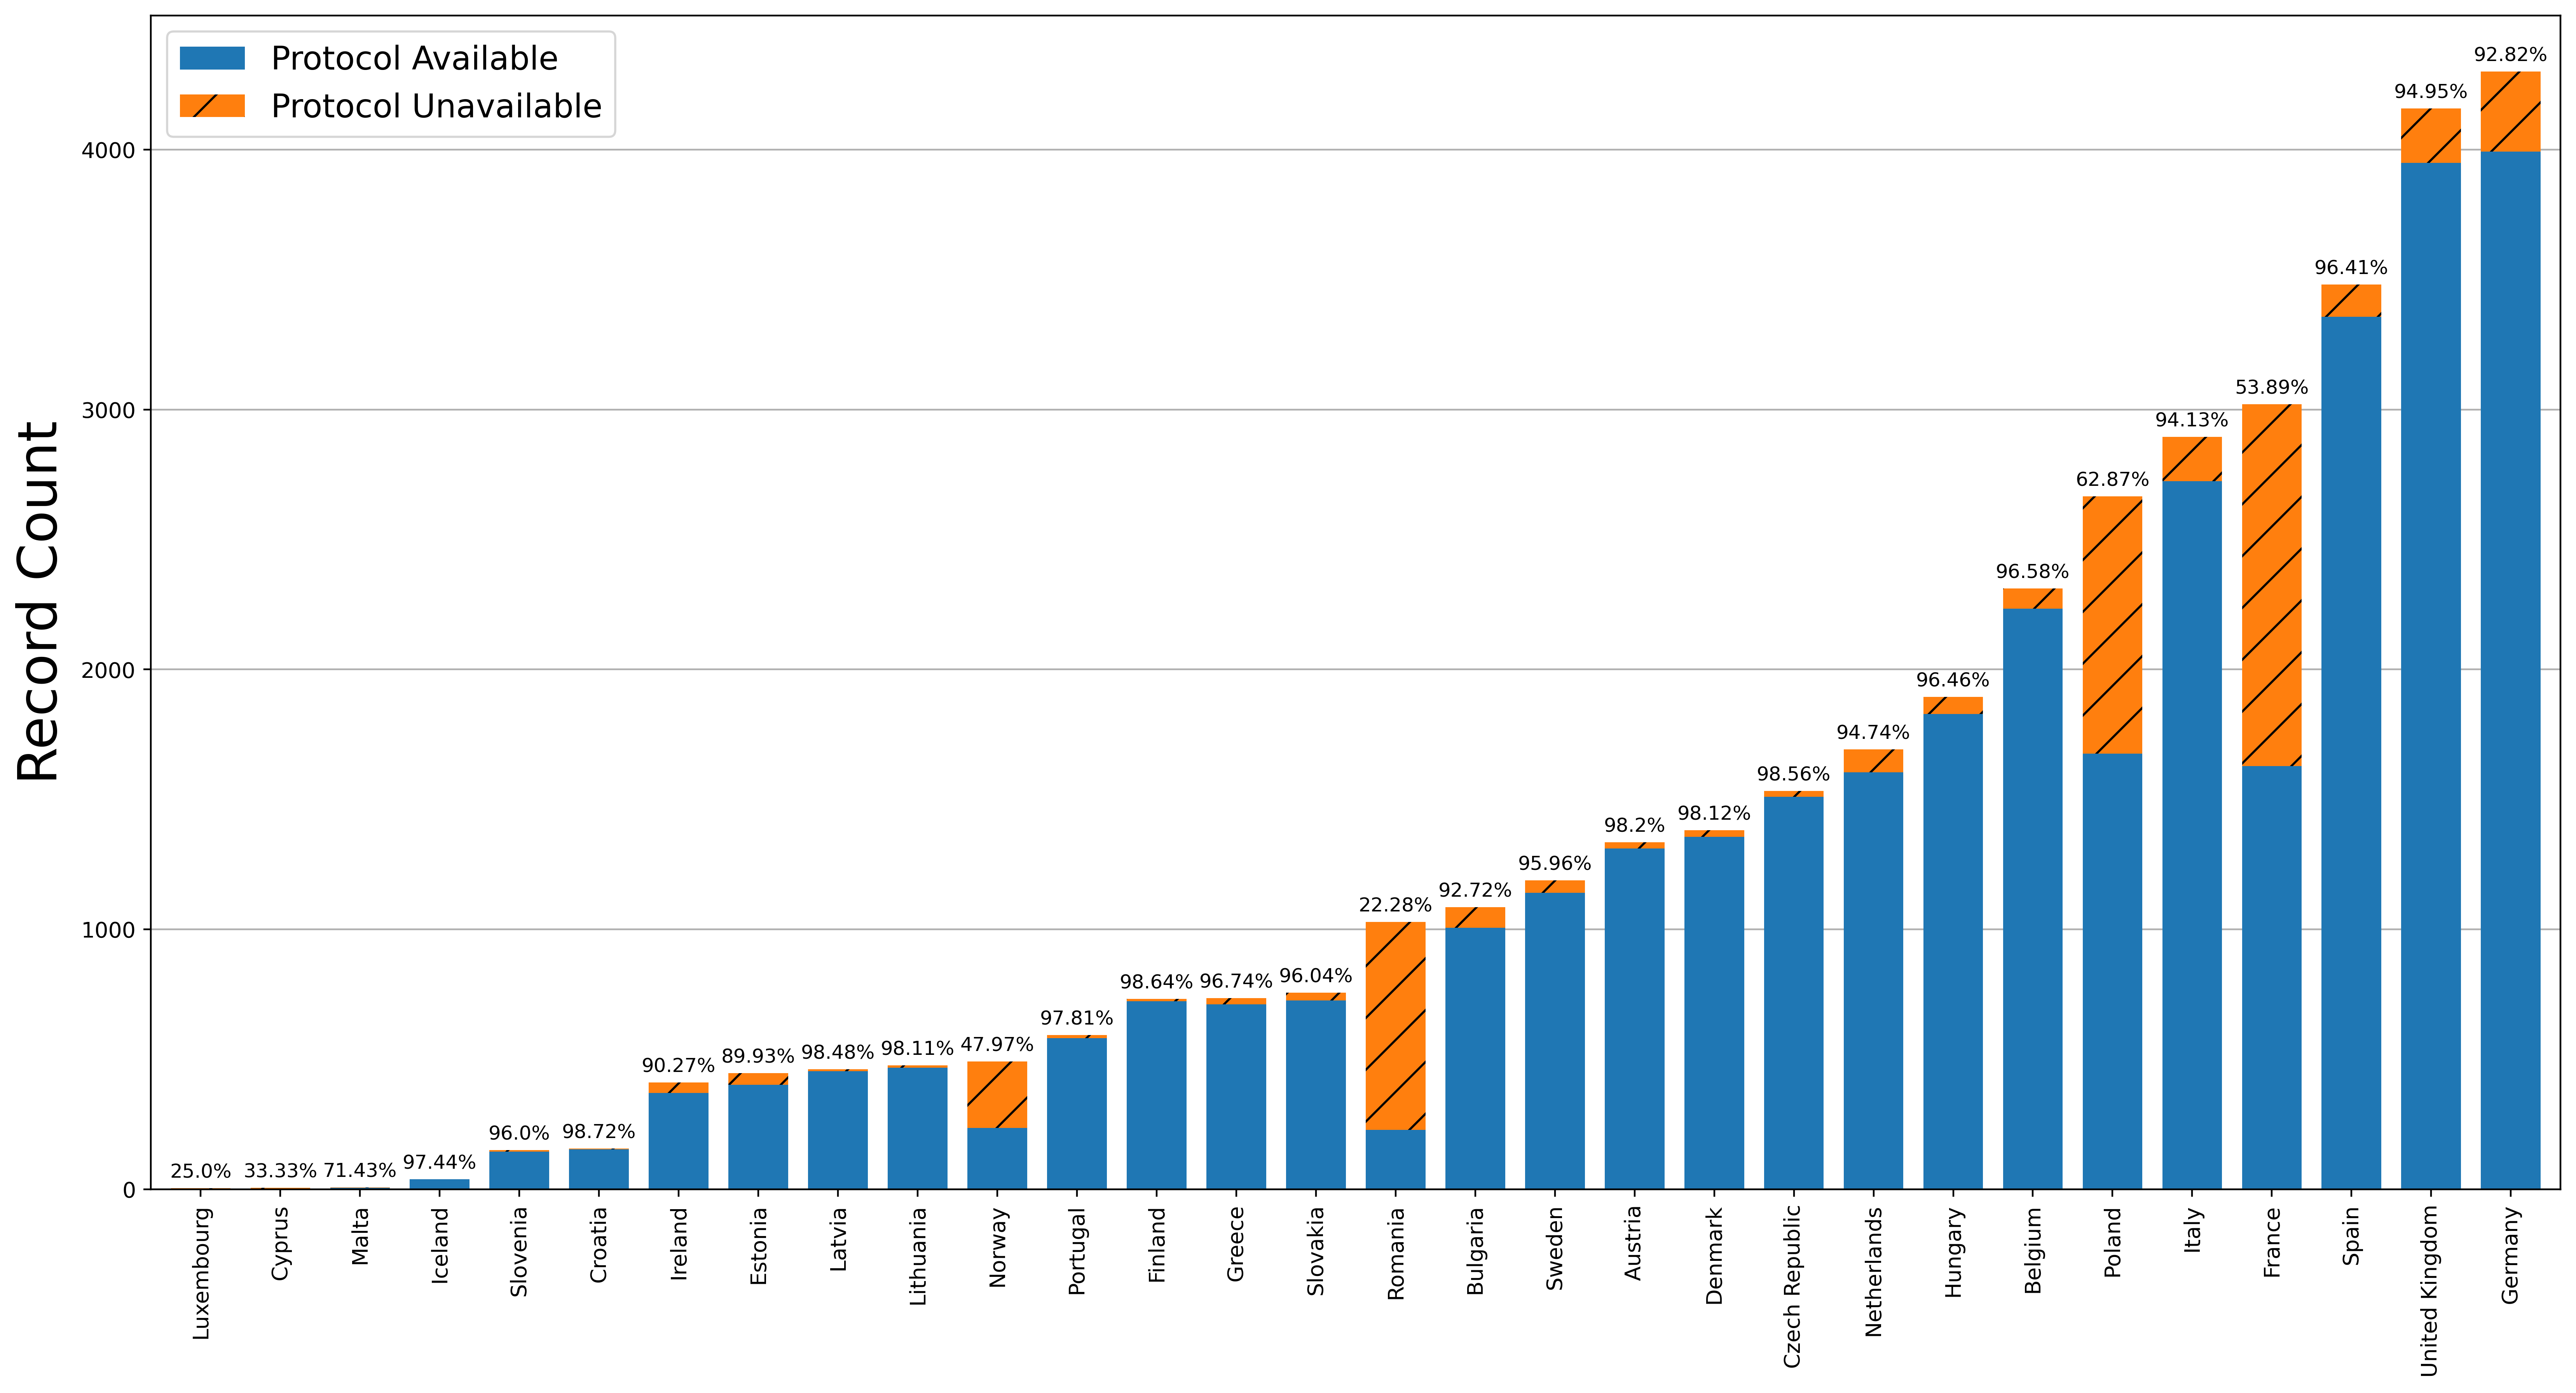

In [12]:
fig, ax = plt.subplots(figsize = (20,10), dpi=400)

sorted_countries = reg_check_no_buffer.sort_values(by='total')
sorted_countries[['accounted', 'unaccounted']].plot.bar(stacked=True, ax=ax,
                                                        legend=False, width=.75)

ax.set_axisbelow(True)
ax.grid(axis='y', zorder=0)

rects = ax.patches[0:30]

for rect, label, y_off in zip(rects, sorted_countries.acct_prct.values, sorted_countries.total.values):
    ax.text(rect.get_x() + rect.get_width() / 2, y_off + 25, str(label) + '%', 
            ha='center', va='bottom', fontsize=9)

for patch in ax.patches[30:]:
    patch.set_hatch('/')

ax.legend(['Protocol Available', 'Protocol Unavailable'], 
           loc='upper left', fontsize=15)
    

#plt.title('CTA Availability for Reported Trials By Country', pad=10, fontsize=23)

plt.ylabel('Record Count', fontsize=25, labelpad=6)
    
plt.show()
#fig.savefig(parent + '/data/Figures/fig_1.jpg', bbox_inches='tight', dpi=400)
#fig.savefig(parent + '/data/Figures/fig_1.eps', bbox_inches='tight', dpi=400)
#saved

# Supplemental Figure 5

This shows the distribution of missing protocols by record entry year but in absolute amount and as a % of all protocols available from that year.

In [16]:
analysis_df = pd.read_csv(parent + '/data/analysis_df_jul22.csv', usecols = ['eudract_number', 'entered_year'])
min_start_date = analysis_df.groupby('eudract_number', as_index=False).min()
by_year_df = missing_protocols.merge(min_start_date, how='left', left_on='trial_id', right_on='eudract_number').drop('eudract_number', axis=1)
grouped_overall = pd.read_csv(parent + '/data/grouped_overall_jul22.csv')

In [17]:
to_graph = by_year_df[['entered_year', 'total_missing']].groupby('entered_year').sum()
to_graph.index = to_graph.index.astype(int)

prct_missing = grouped_overall.merge(to_graph, on='entered_year').set_index('entered_year')
prct_missing['missing_cta_prct'] = (prct_missing.total_missing / prct_missing.eudract_number) * 100

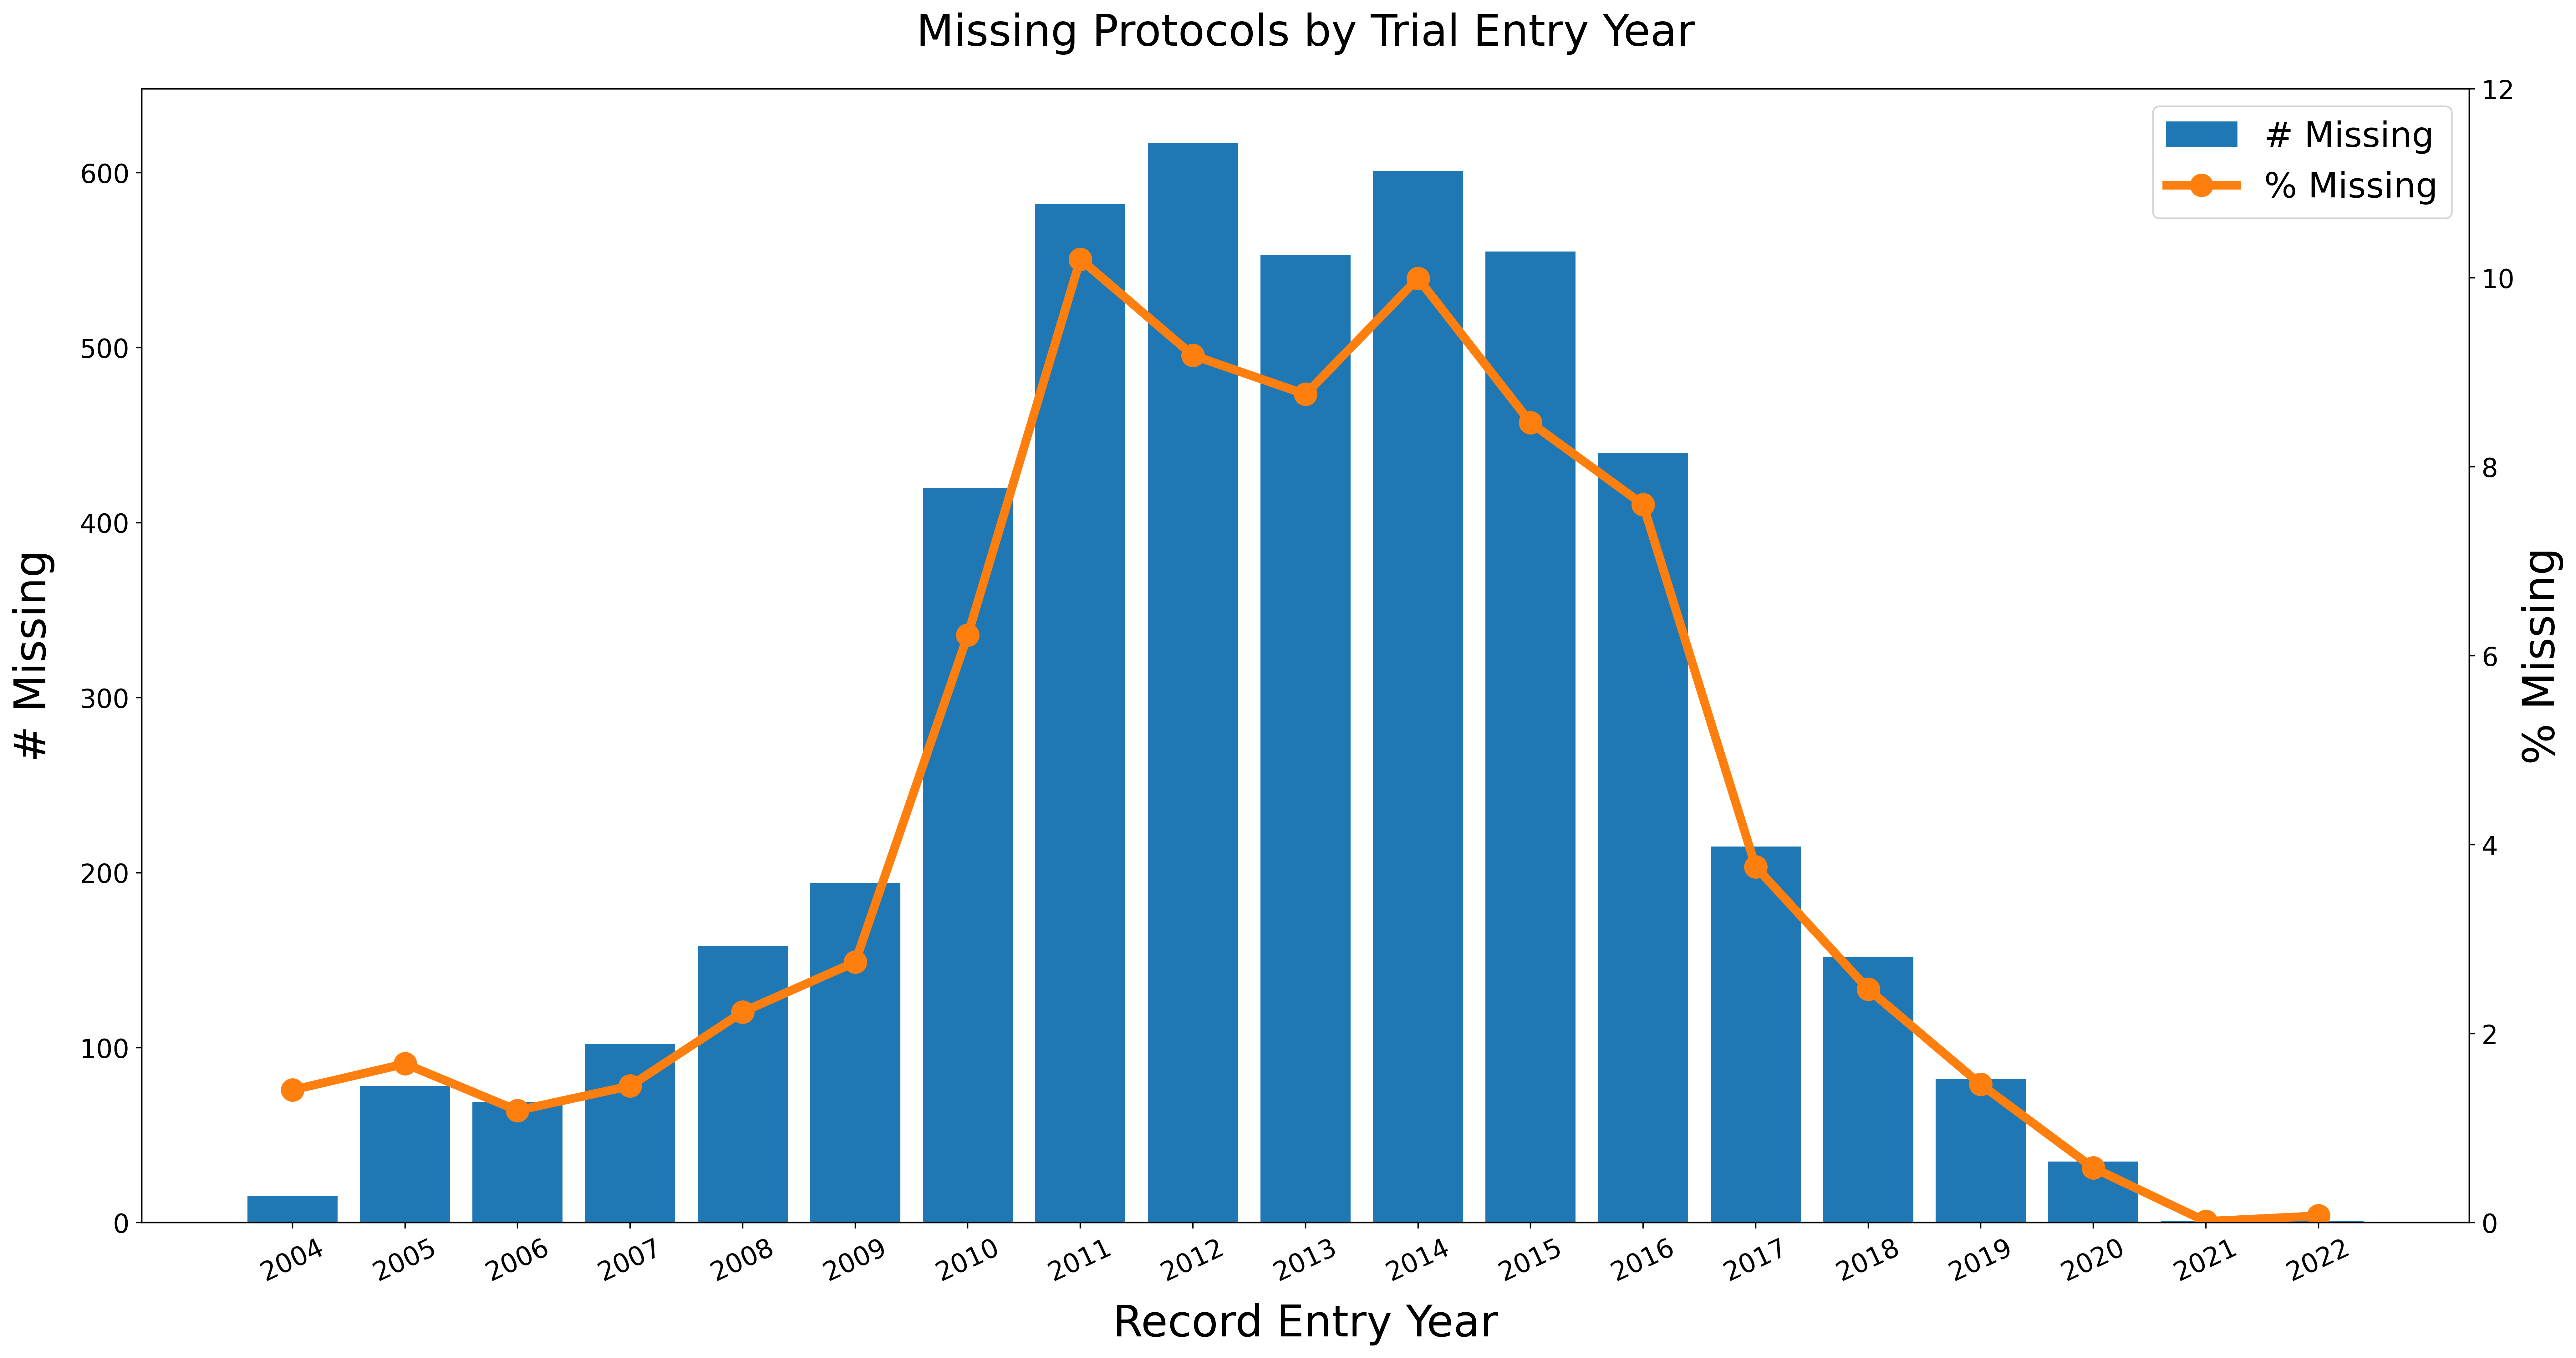

In [20]:
fig, ax = plt.subplots(figsize=(24,12), dpi = 400)

labels = [str(x) for x in range(2004,2023)]

#I have no idea why but I can only get this graph to work with plt.errorbar
#l1 = plt.errorbar(prct_missing.index,prct_missing.missing_cta_prct, lw=5, color='orange', label='% Missing')
l1 = ax.plot(prct_missing.index,prct_missing.missing_cta_prct, marker='.', markersize=25, lw=5, color='C1', 
             label='% Missing')

plt.tick_params(axis='both', which='major', labelsize=15)
#plt.ylabel('# of Missing Trials', fontsize=25, labelpad=10)
plt.xticks(rotation=25)
plt.title("Missing Protocols by Trial Entry Year", pad = 25, fontsize = 25)

ax.set_ylim([0,12])
ax.set_ylabel('# Missing', fontsize=25, labelpad=50)
ax.set_xlabel('Record Entry Year', fontsize=25, labelpad=10)

ax2 = plt.twinx()
ax2.set_axisbelow(True)
#ax.yaxis.grid(linestyle='--', linewidth=.5, zorder=ax.get_zorder()-10)
ax2.bar(to_graph.index, to_graph.total_missing, tick_label=labels)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.set_ylabel('% Missing', fontsize=25, labelpad=30)

ax.yaxis.tick_right()
ax2.yaxis.tick_left()

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
blue_patch = mpatches.Patch(color='C0', label='# Missing')
orange_line = Line2D([0],[0], color='C1', lw=5, label='% Missing', marker='.', markersize=25)

ax.legend(handles=[blue_patch, orange_line], fontsize=20)

plt.show()
#fig.savefig(parent + '/data/Figures/fig_s5.jpg', bbox_inches='tight', dpi=400)
#Saved

# Demo on how to move inclusion date around

As a quick sense check, we can use longer lags between the first available protocol for a country to see if it makes a difference. This can be adjusted using the offseet parameter of the custom compare_enrollment_registration function. However, Supplemental Figure 5 above makes the point that missing protocols are not all clustered around the years in which countries first connected with the EMA system in a better way for the paper. Still a demo on how to look at various date offsets regarding which protocols to include in the analysis is provided below.

In [ ]:
protocols = results_info_filt.trial_countries.to_list()
results_countries = results_info_filt.recruitment_countries.to_list()
start_date = results_info_filt.trial_start_date.to_list()
trial_ids = results_info_filt.trial_id.to_list()

zipped_cats = zip(trial_ids, protocols, results_countries, start_date)

results_sens = compare_enrollment_registration(zipped_cats, offset=6)

missing_sensitivity = pd.DataFrame(results_sens)

In [ ]:
acct_sens = missing_sensitivity.accounted.to_list()
unacct_sens = missing_sensitivity.unaccounted.to_list()

accounted_count_sens = {}
unaccounted_count_sens = {}
for ac, un in zip(acct_sens, unacct_sens):
    if ac:
        for a in ac:
            accounted_count_sens[a] = accounted_count_sens.get(a, 0) + 1
    if un:
        for u in un:
            unaccounted_count_sens[u] = unaccounted_count_sens.get(u, 0) + 1
            
accounted_series_sens = pd.Series(accounted_count_sens)
unaccounted_series_sens = pd.Series(unaccounted_count_sens)

In [ ]:
reg_check_buffer = accounted_series_sens.to_frame().join(unaccounted_series_sens.to_frame(), how='outer', rsuffix='unac').rename({'0': 'accounted', '0unac': 'unaccounted'}, axis=1).fillna(0)

reg_check_buffer['total'] = reg_check_buffer['accounted'] + reg_check_buffer['unaccounted']
reg_check_buffer['acct_prct'] = round((reg_check_buffer['accounted'] / reg_check_buffer['total']) * 100, 2)

reg_check_buffer.head()